In [1]:
import pandas as pd
import folium
from geopy.distance import geodesic 
from sklearn.model_selection import train_test_split
import math
import shutil


In [2]:

pd.set_option('display.max_columns',None)
# CSV raw SCATS_datasets
SCATS_DATA_OCTOBER_2006_CSV_PATH = 'SCATS_datasets/Scats Data October 2006.csv'
SCATS_SITE_LISTING_SPREADSHEET_VICROADS_CSV_PATH = 'SCATS_datasets/SCATSSiteListingSpreadsheet_VicRoads.csv'
TRAFFIC_COUNT_LOCATIONS_WITH_LONG_LAT_CSV_PATH = 'SCATS_datasets/Traffic_Count_Locations_with_LONG_LAT.csv'

# reading the csv files
df_scats_data_october = pd.read_csv(SCATS_DATA_OCTOBER_2006_CSV_PATH,header = 1)
df_scats_site_listing = pd.read_csv(SCATS_SITE_LISTING_SPREADSHEET_VICROADS_CSV_PATH,skiprows=8, header=1)
df_traffic_long_lat = pd.read_csv(TRAFFIC_COUNT_LOCATIONS_WITH_LONG_LAT_CSV_PATH)

In [3]:
# removing the -1 values (-1 values are irrelevant)
df_scats_data_october = df_scats_data_october[df_scats_data_october['HF VicRoads Internal'] != -1]

# **CD_MELWAYS Values**

#### SCATSSiteListingSpreadsheet ("Map reference" column)
- Based on my analysis and assumptions, the SCATSSiteListingSpreadsheet contains all of Boroondarah SCATS sites (4500+ SCATS sites). This includes the Intersections (INT), Pedestrian Crossing (POS), etc, as mentioned in the Data information workbook.

#### SCATS Data October 2006 ("CD_MELWAY" column)
- This spreadsheet contains all the traffic flow recorded over the span of 31 days in 15 minutes intervals within 40 different SCATS sites. 

#### Usage
- In the SCATS Data October 2006, there are 40 unique "CD_MELWAY" values, which aligns with "Map reference" values in the SCATSSiteListingSpreadsheet.
- Having this information we can eliminate all the other values in SCATSSiteListingSpreadsheet that's not in SCATS Data October 2006 data set. The 'CD_MELWAYS' allow us to pinpoint the connections between each nodes. In simple terms, we pick only the useful rows in SCATSSiteListingSpreadsheet judging from the values we have in SCATS Data October 2006. **Only a handful of SCATSSiteListingSpreadsheet values are useful**  
- The SCATS number in the SCATS Data October 2006 represents a range of SCATS sites, corresponding to the SCATS sites in SCATSSiteListingSpreadsheet.

In [4]:
df_scats_data_october = df_scats_data_october.rename(columns={"CD_MELWAY": "CD_MELWAYS"})
df_scats_site_listing = df_scats_site_listing.rename(columns={"Map reference ": "CD_MELWAYS"})

df_scats_data_october["CD_MELWAYS"] = df_scats_data_october["CD_MELWAYS"].str.strip().str.replace(' ','')
df_scats_site_listing["CD_MELWAYS"] = df_scats_site_listing["CD_MELWAYS"].str.strip().str.replace(' ','')

In [5]:
df_scats_data_october.head()

,SCATS Number,Location,CD_MELWAYS,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,Unnamed: 106,Unnamed: 107,Unnamed: 108
0,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34,NaN,NaN,NaN
1,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26,NaN,NaN,NaN
2,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40,NaN,NaN,NaN
3,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44,NaN,NaN,NaN
4,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36,NaN,NaN,NaN


In [6]:
common_cd_melways = df_scats_data_october['CD_MELWAYS'].dropna().unique()
len(common_cd_melways)

40

In [7]:
common_cd_melways


array(['060G10', '060H06', '046H08', '045C02', '031K12', '032D11',
       '059J09', '045A08', '045B08', '045J10', '046A10', '046H11',
       '046D11', '046E03', '045C06', '060H02', '060G07', '059K01',
       '059K02', '045K02', '045K04', '045K07', '045J09', '059J01',
       '059H05', '046B02', '046E05', '046D08', '002HJ07', '045B10',
       '045D10', '045F11', '045D12', '045G12', '059F05', '045G04',
       '045E06', '045D06', '002HJ11', '002HF02'], dtype=object)

In [8]:

df_scats_data_october['SCATS Number'].unique()

array([ 970, 2000, 2200, 2820, 2825, 2827, 2846, 3001, 3002, 3120, 3122,
       3126, 3127, 3180, 3662, 3682, 3685, 3804, 3812, 4030, 4032, 4034,
       4035, 4040, 4043, 4051, 4057, 4063, 4262, 4263, 4264, 4266, 4270,
       4272, 4273, 4321, 4324, 4335, 4812, 4821])

In [9]:
filtered_site_listing_vicroads = df_scats_site_listing[df_scats_site_listing['CD_MELWAYS'].isin(common_cd_melways)]
filtered_site_listing_vicroads

,Site Number,Location Description,Site Type,Directory,CD_MELWAYS
128,4069,BALWYN NR MILLAH,POS,Melway,046D08
129,4057,BALWYN/BELMORE,INT,Melway,046E05
145,3001,BARKERS/CHURCH/HIGH,INT,Melway,045A08
146,3002,BARKERS/DENMARK/POWER,INT,Melway,045B08
460,4055,BULLEEN NR LEONIS,POS,Melway,032D11
...,...,...,...,...,...
4173,3687,WARRIGAL NR POULTER,POS,Melway,060G10
4181,970,WARRIGAL/HIGH ST RD,INT,Melway,060G10
4182,3685,WARRIGAL/HIGHBURY,INT,Melway,060G07
4189,3682,WARRIGAL/RIVERSDALE,INT,Melway,060H02


In [10]:
# Handling missing values for Latitudes and longitudes for the SCAT Number 4266 using mean imputation
# Filter for SCATS site number 4266
site_4266 = df_scats_data_october[df_scats_data_october['SCATS Number'] == 4266]

# Calculating the average latitude and longitude for rows where they are non-zero
valid_latitudes = site_4266[site_4266['NB_LATITUDE'] != 0]['NB_LATITUDE'].astype(float)
valid_longitudes = site_4266[site_4266['NB_LONGITUDE'] != 0]['NB_LONGITUDE'].astype(float)
average_latitude = valid_latitudes.mean()
average_longitude = valid_longitudes.mean()

df_scats_data_october.loc[(df_scats_data_october['SCATS Number'] == 4266) & (df_scats_data_october['NB_LATITUDE'] == 0), 'NB_LATITUDE'] = average_latitude
df_scats_data_october.loc[(df_scats_data_october['SCATS Number'] == 4266) & (df_scats_data_october['NB_LONGITUDE'] == 0), 'NB_LONGITUDE'] = average_longitude

df_scats_data_october[df_scats_data_october['SCATS Number'] == 4266]

,SCATS Number,Location,CD_MELWAYS,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,Unnamed: 106,Unnamed: 107,Unnamed: 108
3311,4266,AUBURN_RD N of BURWOOD_RD,045F11,-37.825297,145.043447,4397,653,1,1,1/10/06,44,53,36,35,37,25,36,26,17,21,18,16,11,18,17,15,7,15,12,15,10,11,9,19,18,25,29,38,34,29,33,47,43,43,58,67,76,96,113,135,135,140,126,132,103,172,147,179,125,132,160,182,161,161,140,136,129,129,131,131,119,154,134,117,107,139,150,133,130,118,155,132,140,126,128,93,104,76,92,79,62,72,66,71,89,89,92,46,61,46,63,53,59,37,25,31,NaN,NaN,NaN
3312,4266,AUBURN_RD N of BURWOOD_RD,045F11,-37.825297,145.043447,4397,653,1,1,2/10/06,25,12,12,14,8,14,11,4,5,5,4,5,5,4,5,9,7,10,6,18,12,29,30,48,55,70,137,182,194,290,292,306,268,290,256,266,194,215,205,192,190,135,162,177,169,142,143,148,157,154,155,163,175,155,133,161,177,164,140,152,164,203,218,199,203,172,197,169,203,190,203,193,178,173,171,178,137,132,106,71,76,72,69,55,60,59,64,67,47,45,47,31,26,18,23,19,NaN,NaN,NaN
3313,4266,AUBURN_RD N of BURWOOD_RD,045F11,-37.825297,145.043447,4397,653,1,1,3/10/06,11,13,11,5,9,8,4,3,3,1,2,7,6,2,7,1,5,5,11,11,16,29,46,54,55,113,151,194,216,289,322,263,308,303,279,295,221,206,180,226,188,166,193,152,141,154,189,163,169,173,182,203,165,171,151,177,163,214,151,178,170,175,216,196,205,204,203,197,192,229,181,213,189,193,179,165,155,146,123,104,108,90,67,63,85,95,57,83,69,54,50,42,30,35,22,16,NaN,NaN,NaN
3314,4266,AUBURN_RD N of BURWOOD_RD,045F11,-37.825297,145.043447,4397,653,1,1,4/10/06,28,14,10,13,4,7,4,8,4,1,2,6,1,3,4,3,3,4,6,16,12,20,34,56,61,101,147,169,246,278,330,266,312,277,272,295,231,227,227,203,168,169,201,179,172,153,168,172,159,180,178,154,156,171,161,161,151,160,155,165,175,203,209,174,171,207,213,183,224,189,192,217,181,203,164,105,168,165,122,66,95,99,73,73,75,83,75,67,77,57,65,44,35,29,26,20,NaN,NaN,NaN
3315,4266,AUBURN_RD N of BURWOOD_RD,045F11,-37.825297,145.043447,4397,653,1,1,5/10/06,17,19,16,11,8,3,7,8,8,6,8,8,4,4,7,3,8,3,8,18,16,25,35,55,59,100,136,169,209,258,275,311,255,294,258,306,240,220,234,210,187,175,193,204,150,173,190,179,186,151,203,165,144,172,164,171,203,193,172,181,203,202,197,208,202,192,176,205,199,201,197,211,195,201,198,183,181,167,91,115,116,97,102,88,83,90,66,77,81,64,58,45,39,33,24,31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3430,4266,BURWOOD_RD W of AUBURN_RD,045F11,-37.825180,145.043010,4243,653,7,1,27/10/06,53,52,49,34,38,34,30,17,24,29,18,22,15,19,14,19,7,17,11,21,16,19,9,24,31,41,46,86,93,105,114,133,142,166,196,170,138,165,143,164,151,158,170,173,182,179,178,189,192,162,188,179,186,185,197,180,188,193,209,193,214,224,215,212,247,244,245,280,262,318,267,315,260,272,237,171,198,178,161,178,134,134,140,137,142,168,126,105,127,118,142,110,104,105,109,100,NaN,NaN,NaN
3431,4266,BURWOOD_RD W of AUBURN_RD,045F11,-37.825180,145.043010,4243,653,7,1,28/10/06,97,74,86,84,57,62,67,65,42,33,44,34,36,29,37,24,23,25,26,24,14,20,12,20,19,21,28,43,47,46,66,76,89,114,104,130,147,135,162,162,168,162,187,181,188,177,208,166,176,186,203,210,195,201,210,204,169,172,184,191,221,215,194,172,193,195,221,205,175,195,149,174,176,165,148,126,138,133,101,116,129,100,100,101,118,110,101,110,100,121,88,107,107

## **Reshaping the tables for machine feeding**


In [11]:
# removing the unnecessary columns
cols_to_drop = ['Location', 'NB_LATITUDE', 'NB_LONGITUDE', 'HF VicRoads Internal', 'VR Internal Stat', 'VR Internal Loc', 'NB_TYPE_SURVEY', 'Unnamed: 106', 'Unnamed: 107', 'Unnamed: 108']
ml_train_october = df_scats_data_october.copy()
ml_train_october = ml_train_october.drop(columns=cols_to_drop, axis=1)

In [12]:

ml_train_october.head()

,SCATS Number,CD_MELWAYS,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,970,060G10,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34
1,970,060G10,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26
2,970,060G10,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40
3,970,060G10,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44
4,970,060G10,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36


#### Creating a dataframe named 'lat_long_intersection' to store the latitude and longitudes of each intersection to find the neighbouring intersections in future 


In [13]:
#Extracting the first occurrence of each unique SCATS Number from df_scats_data_october
first_occurrences = df_scats_data_october.groupby('SCATS Number', as_index=False).first()
first_occurrences = first_occurrences[['SCATS Number', 'NB_LATITUDE', 'NB_LONGITUDE','CD_MELWAYS']]

#Extracting relevant columns from df_scats_site_listing
site_listing = df_scats_site_listing[['Site Number', 'Location Description', 'Site Type']].copy()

#Renaming 'Site Number' to 'Scats_number' for consistent naming
site_listing.rename(columns={'Site Number': 'Scats_number', 'Location Description': 'Site description'}, inplace=True)

#Merging the two DataFrames based on SCATS number
lat_long_intersection = pd.merge(
    first_occurrences, 
    site_listing, 
    left_on='SCATS Number', 
    right_on='Scats_number',  
    how='inner'  
)

lat_long_intersection.rename(columns={'SCATS Number': 'Scats_number', 'NB_LATITUDE': 'Latitude', 'NB_LONGITUDE': 'Longitude'}, inplace=True)
lat_long_intersection = lat_long_intersection.loc[:, ~lat_long_intersection.columns.duplicated()]
lat_long_intersection.drop_duplicates(inplace=True)
lat_long_intersection.sort_values(by='Scats_number', inplace=True)


lat_long_intersection.reset_index(drop=True, inplace=True)
lat_long_intersection = lat_long_intersection[['Scats_number', 'Site description', 'Site Type', 'Latitude', 'Longitude']]
lat_long_intersection


,Scats_number,Site description,Site Type,Latitude,Longitude
0,970,WARRIGAL/HIGH ST RD,INT,-37.867030,145.091590
1,2000,BURWOOD HWY/WARRIGAL,INT,-37.851683,145.094346
2,2200,MAROONDAH/UNION,INT,-37.816310,145.098120
3,2820,CHANDLER HWY/PRINCESS ST,INT,-37.794770,145.030770
4,2825,EASTERN/BURKE ON RAMP,INT,-37.786610,145.062020
5,2827,EASTERN FWY/BULLEEN/THOMPSONS,INT,-37.780930,145.077330
6,2846,MONASH/HIGH/WILLS,INT,-37.861267,145.058038
7,3001,BARKERS/CHURCH/HIGH,INT,-37.814410,145.022430
8,3002,BARKERS/DENMARK/POWER,INT,-37.814890,145.026630
9,3120,BURKE/CANTERBURY,INT,-37.822640,145.057340


In [14]:
# Specifying the file path
output_directory = "C:/Users/DELL/OneDrive/Documents/GitHub/Traffic-Flow-Prediction-System-TPFS/data/"
original_filename= "unique_scats_boroondara.csv"
original_path  = f"{output_directory}{output_filename}"

# Saving the DataFrame
lat_long_intersection.to_csv(output_path, index=False)

print(f"DataFrame has been saved as '{output_filename}' in the '{output_directory}' directory.")


NameError: name 'output_filename' is not defined

In [357]:
# Step 1: Calculate the average latitude and longitude for each unique SCATS Number
# Using groupby and aggregate function to calculate the mean of unique latitude and longitude values
avg_lat_long = (
    df_scats_data_october.groupby('SCATS Number', as_index=False)
    .agg({'NB_LATITUDE': lambda x: x.unique().mean(), 'NB_LONGITUDE': lambda x: x.unique().mean()})
)

# Extracting relevant columns
avg_lat_long = avg_lat_long[['SCATS Number', 'NB_LATITUDE', 'NB_LONGITUDE']]

# Step 2: Extract relevant columns from df_scats_site_listing
site_listing = df_scats_site_listing[['Site Number', 'Location Description', 'Site Type']].copy()

# Renaming 'Site Number' to 'Scats_number' for consistent naming
site_listing.rename(columns={'Site Number': 'Scats_number', 'Location Description': 'Site description'}, inplace=True)

# Step 3: Merge the two DataFrames based on SCATS number using the calculated averages
lat_long_intersection_avg = pd.merge(
    avg_lat_long,
    site_listing,
    left_on='SCATS Number',
    right_on='Scats_number',
    how='inner'
)

# Renaming columns for consistency
lat_long_intersection_avg.rename(columns={'SCATS Number': 'Scats_number', 'NB_LATITUDE': 'Latitude', 'NB_LONGITUDE': 'Longitude'}, inplace=True)

# Dropping redundant and duplicated columns
lat_long_intersection_avg = lat_long_intersection_avg.loc[:, ~lat_long_intersection_avg.columns.duplicated()]

# Sorting and resetting the index
lat_long_intersection_avg.sort_values(by='Scats_number', inplace=True)
lat_long_intersection_avg.reset_index(drop=True, inplace=True)

# Rearrange columns for better readability
lat_long_intersection_avg = lat_long_intersection_avg[['Scats_number', 'Site description', 'Site Type', 'Latitude', 'Longitude']]

# Display the final DataFrame
lat_long_intersection_avg


,Scats_number,Site description,Site Type,Latitude,Longitude
0,970,WARRIGAL/HIGH ST RD,INT,-37.867303,145.091507
1,2000,BURWOOD HWY/WARRIGAL,INT,-37.851923,145.094324
2,2200,MAROONDAH/UNION,INT,-37.816540,145.098047
3,2820,CHANDLER HWY/PRINCESS ST,INT,-37.794785,145.030460
4,2825,EASTERN/BURKE ON RAMP,INT,-37.786610,145.062020
5,2827,EASTERN FWY/BULLEEN/THOMPSONS,INT,-37.781739,145.077331
6,2827,EASTERN FWY/BULLEEN/THOMPSONS,INT,-37.781739,145.077331
7,2846,MONASH/HIGH/WILLS,INT,-37.861446,145.058019
8,2846,MONASH/HIGH/WILLS,INT,-37.861446,145.058019
9,2846,MONASH/HIGH/WILLS,INT,-37.861446,145.058019


In [355]:
#Using feographical map with Scats_number as a reference for manually handling site description for proper identification of neighbouring intersections
#Creating a base map centered around the mean latitude and longitude
map_center = [lat_long_intersection['Latitude'].mean(), lat_long_intersection['Longitude'].mean()]
mymap = folium.Map(location=[-37.86703, 145.09159], zoom_start=12.5)

#Markers for each intersection
for i, row in lat_long_intersection.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<b>SCATS Number:</b> {row['Scats_number']}<br><b>Description:</b> {row['Site description']}<br><b>Site Type:</b> {row['Site Type']}",
        tooltip=row['Scats_number'],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(mymap)
mymap


In [337]:
'''# copy of the unique_scats_baroondara csv for manual editing of site description

manually_edited_file = "unique_scats_boroondara_manual.csv"
edited_file_path = f"{output_directory}{manually_edited_file}"
shutil.copy(original_path, edited_file_path)
print(f"A copy for manual editing has been saved as '{manually_edited_file}' in the '{output_directory}' directory.")
'''


A copy for manual editing has been saved as 'unique_scats_boroondara_manual.csv' in the 'C:/Users/DELL/OneDrive/Documents/GitHub/Traffic-Flow-Prediction-System-TPFS/data/' directory.


In [343]:
#Loading the manually editable copy into a new DataFrame variable
lat_long_intersection_new = pd.read_csv(edited_file_path)
lat_long_intersection_new

,Scats_number,Site description,Site Type,Latitude,Longitude
0,970,WARRIGAL/HIGH ST RD,INT,-37.867030,145.091590
1,2000,BURWOOD HWY/WARRIGAL/TOORAK,INT,-37.851683,145.094346
2,2200,MAROONDAH/UNION,INT,-37.816310,145.098120
3,2820,CHANDLER HWY/PRINCESS/VALERIE/EASTERN,INT,-37.794770,145.030770
4,2825,EASTERN/BURKE,INT,-37.786610,145.062020
5,2827,EASTERN/BULLEEN/THOMPSONS,INT,-37.780930,145.077330
6,2846,MONASH/HIGH ST RD,INT,-37.861267,145.058038
7,3001,BARKERS/CHURCH/HIGH,INT,-37.814410,145.022430
8,3002,BARKERS/DENMARK/POWER,INT,-37.814890,145.026630
9,3120,BURKE/CANTERBURY,INT,-37.822640,145.057340


#### Trying to find the neighbouring intersections 

In [361]:

#Creating a base map centered around the mean latitude and longitude with correct site description for reference for evaluating the neighbouring intersections 
map_center = [lat_long_intersection_new['Latitude'].mean(), lat_long_intersection_new['Longitude'].mean()]
mymap = folium.Map(location=[-37.86703, 145.09159], zoom_start=12.5)

#Markers for each intersection
for i, row in lat_long_intersection_new.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"<b>SCATS Number:</b> {row['Scats_number']}<br><b>Description:</b> {row['Site description']}<br><b>Site Type:</b> {row['Site Type']}",
        tooltip=row['Scats_number'],
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(mymap)
mymap


### Setting the foundation process for calculating the neighbours for a particular intersection 
To calculate the neighboring intersections for a given intersection, the approach involves identifying the closest intersections in each of the four cardinal directions (North, East, South, and West). First, we identify all potential neighbors that share a common road with the current intersection. We then compute the distance and angle between the current intersection and each of these potential neighbors. The closest intersection is used as a reference point to calculate relative angles for all other potential neighbors. These relative angles are then segmented into four directional groups (0-90 degrees for North, 90-180 degrees for East, 180-270 degrees for South, and 270-360 degrees for West). For each directional group, we identify the closest intersection within that segment. The result is a list of the nearest intersections in each direction, providing a clear spatial relationship of neighboring intersections for the given intersection.

In [367]:
# Constants for angle segmentation
direction_segments = 4 # representing the four directions north, east, west and south 
angle_increment = 360 / direction_segments # to move from one direction to other there will be an increment of 90 degrees 

# Function to extract road connections from site details
def extract_road_connections(site_info):
    roads = site_info.split('/')
    valid_roads = []
  
    for road in roads:
        # Check if the road name is not empty
        if road != "":
            # Add the valid road name to the list
            valid_roads.append(road)
    return valid_roads

# Function to calculate the angle between two locations
def compute_angle_between_locations(location1, location2):
    delta_x = location2[1] - location1[1]
    delta_y = location2[0] - location1[0]
    
    
    angle_in_degrees = math.degrees(math.atan2(delta_y, delta_x))  # Calculate angle with respect to x-axis
    return angle_in_degrees

# Function to compute distance between two geographical points
def compute_geodesic_distance(point1, point2):
    return geodesic(point1, point2).km


# Function to compute adjusted angles in order to find the angle between intersections to determine the directional relationship.   
def compute_adjusted_angles(angles_list, base_angle, angle_shift=0):
    adjusted_angles = []
    for angle in angles_list:
        adjusted_angle = angle - base_angle + angle_shift
        adjusted_angle = adjusted_angle % 360
        adjusted_angles.append(adjusted_angle)
    return adjusted_angles


# Function to identify neighboring sites for a given intersection ie finding the closest neighboring intersections in each of the four directions (north, east, south, and west) for a given intersection 
     
def identify_neighboring_sites(current_intersection, all_intersections):
    nearby_sites = []
    current_coordinates = (current_intersection['Latitude'], current_intersection['Longitude'])
    connected_roads = extract_road_connections(current_intersection['Site description'])

    for road in connected_roads:
        # Find neighboring intersections based on common roads
        candidates = [neighbor for neighbor in all_intersections if neighbor['Scats_number'] != current_intersection['Scats_number'] and road in extract_road_connections(neighbor['Site description'])]
        
        if not candidates:
            continue

        angle_list = [compute_angle_between_locations(current_coordinates, (neighbor['Latitude'], neighbor['Longitude'])) for neighbor in candidates]
        distance_list = [compute_geodesic_distance(current_coordinates, (neighbor['Latitude'], neighbor['Longitude'])) for neighbor in candidates]

        if distance_list:
            # Identify the closest intersection in each direction segment
            min_distance = min(distance_list)
            closest_index = distance_list.index(min_distance)
            reference_angle = angle_list[closest_index]

            # Calculate relative angles for directional segmentation
            adjusted_angles = compute_adjusted_angles(angle_list, reference_angle, angle_shift=-angle_increment/2)

            for i in range(direction_segments):        #0 to 90 degrees — First segment (North).
                                                        #90 to 180 degrees — Second segment (East).
                                                        #180 to 270 degrees — Third segment (South).
                                                        #270 to 360 degrees — Fourth segment (West).
                start_angle = angle_increment * i
                end_angle = angle_increment * (i + 1)

                sites_in_segment = []
                distances_in_segment = []
                
                # Identify intersections within the specified angle range
                for j in range(len(adjusted_angles)):
                    if start_angle <= adjusted_angles[j] <= end_angle:
                        sites_in_segment.append(candidates[j])
                        distances_in_segment.append(distance_list[j])

                # Determine the closest intersection within the current segment
                if distances_in_segment:
                    nearest_site = sites_in_segment[min(range(len(distances_in_segment)), key=distances_in_segment.__getitem__)]
                    nearby_sites.append(str(nearest_site['Scats_number']))  # Convert to string
    
    return nearby_sites


### Calculating neighbouring intersections for all the Scats_number in lat_long_intersections 

In [370]:
#Function to process all intersections and find their neighbors
def analyze_all_sites(dataframe):
    sites_list = dataframe.to_dict('records') #list of dictionaries, where each dictionary represents a row in the DataFrame
    neighbors_map = {}    #store the list of neighbors for each intersection

    # Process each intersection(scats_number) to identify its neighbors
    for site in sites_list:
        neighbors = identify_neighboring_sites(site, sites_list)      
        neighbors_map[site['Scats_number']] = ";".join(neighbors)

    # adding identified neighbours to dataframe 
    dataframe['Neighbours'] = dataframe['Scats_number'].map(neighbors_map)
    return dataframe

lat_long_intersection_neighbours = lat_long_intersection_new.copy()
lat_long_intersection_neighbours = analyze_all_sites(lat_long_intersection_neighbours)

lat_long_intersection_neighbours

,Scats_number,Site description,Site Type,Latitude,Longitude,Neighbours
0,970,WARRIGAL/HIGH ST RD,INT,-37.867030,145.091590,3685;2846
1,2000,BURWOOD HWY/WARRIGAL/TOORAK,INT,-37.851683,145.094346,3682;3685;4043
2,2200,MAROONDAH/UNION,INT,-37.816310,145.098120,4063;3126
3,2820,CHANDLER HWY/PRINCESS/VALERIE/EASTERN,INT,-37.794770,145.030770,3662;4321;2825
4,2825,EASTERN/BURKE,INT,-37.786610,145.062020,2820;2827;4030
5,2827,EASTERN/BULLEEN/THOMPSONS,INT,-37.780930,145.077330,2825;4051
6,2846,MONASH/HIGH ST RD,INT,-37.861267,145.058038,970
7,3001,BARKERS/CHURCH/HIGH,INT,-37.814410,145.022430,4821;3002;4262;3662
8,3002,BARKERS/DENMARK/POWER,INT,-37.814890,145.026630,4035;3001;3662;4263
9,3120,BURKE/CANTERBURY,INT,-37.822640,145.057340,4040;4035;3122


In [363]:
output_filename_neighbours = "neighbouring_intersections.csv"
output_path_neighbours = f"{output_directory}{output_filename_neighbours}"

# Saving the DataFrame as a CSV file
lat_long_intersection_neighbours.to_csv(output_path_neighbours, index=False)

In [3]:
! pip install geopy


In [21]:
site_listing

,Scats_number,Site description,Site Type
0,964,ABBOTTS/CLELANDS DEVELOPMENTS,INT
1,968,ABBOTTS/GAINE/MONASH,INT
2,972,ABBOTTS/NATIONAL,INT
3,983,ABBOTTS/REMINGTON,INT
4,1053,ABBOTTSFORD/HAINES,INT
...,...,...,...
4510,5081,YARRA/LT MALOP,INT
4511,4897,YORK/FERRARS,INT
4512,1296,YOUNG NR PLAYNE,FLASH PX
4513,741,YOUNG NR STATION,POS


## **Creating a new reshaped table (making it fit for training)**

- based on xiaochus github, the dataframe is layed out this way for training.
- **this is just a general layout, we'll need to figure out the dataframes features and adjust xiaochus training model to fit our dataframe**

In [23]:
# initialize the new dataframe
final_df_scats_october = pd.DataFrame()

# iterating through the entire ml_train_october DF
for i in range(len(ml_train_october)):
    # extract the relevant columns
    date = ml_train_october.iloc[i]['Date']
    cd_melways = ml_train_october.iloc[i]['CD_MELWAYS']
    flow_data = ml_train_october.iloc[i, 3:] #extracting V00 - V95 columns
    scat_number = ml_train_october.iloc[i]['SCATS Number']
    # create a temporary dataframe for this row's data
    temp_df = pd.DataFrame({
        'Date': date,
        'CD_MELWAYS': cd_melways,
        'Scat_Number': scat_number,
        '15_Minute_Intervals': flow_data.index,
        'Flow Vehicles': flow_data.values,
    })
    
    # append the temporary dataframe to the final dataframe
    final_df_scats_october = pd.concat([final_df_scats_october, temp_df], ignore_index=True)

In [24]:
ml_train_october

,SCATS Number,CD_MELWAYS,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95
0,970,060G10,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34
1,970,060G10,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26
2,970,060G10,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40
3,970,060G10,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44
4,970,060G10,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,4821,002HF02,27/10/06,51,56,43,29,35,19,24,21,15,20,19,14,16,15,13,14,11,15,14,21,17,22,34,51,36,66,109,103,113,136,138,141,218,174,167,168,166,146,163,142,170,158,173,147,194,173,186,151,206,199,218,197,201,197,232,206,205,212,194,215,224,229,253,223,240,261,305,268,303,270,333,264,341,255,214,229,224,204,150,189,164,167,115,133,127,122,122,121,127,103,122,124,117,99,108,88
4188,4821,002HF02,28/10/06,91,87,89,72,64,81,58,47,52,43,33,47,36,37,27,24,23,35,26,15,16,25,27,24,29,30,38,55,57,50,80,96,79,74,105,110,129,140,154,184,176,163,196,188,193,191,219,224,200,240,223,236,225,200,226,222,216,223,227,219,221,211,236,218,235,242,220,177,201,185,175,154,156,159,164,128,132,125,112,137,119,118,133,129,114,102,93,93,93,105,105,112,82,97,106,107
4189,4821,002HF02,29/10/06,100,81,89,73,100,83,68,53,55,47,53,63,64,47,44,38,42,40,41,31,41,39,37,34,30,30,35,33,28,36,43,39,35,52,38,48,57,68,79,100,101,127,113,127,128,167,151,165,178,191,212,199,219,212,177,239,191,188,218,203,228,221,184,199,201,189,229,190,198,180,169,168,165,138,139,123,122,100,92,116,95,93,102,106,112,93,87,118,83,76,66,64,77,60,49,45
4190,4821,002HF02,30/10/06,40,29,36,20,24,17,17,18,22,13,16,19,16,15,7,11,11,15,9,19,22,22,24,47,40,51,87,97,100,118,128,163,200,182,159,146,145,133,131,158,144,151,163,154,156,181,153,167,169,207,172,181,191,175,193,159,227,197,197,215,212,216,

In [25]:
final_df_scats_october

,Date,CD_MELWAYS,Scat_Number,15_Minute_Intervals,Flow Vehicles
0,1/10/06,060G10,970,V00,86
1,1/10/06,060G10,970,V01,83
2,1/10/06,060G10,970,V02,52
3,1/10/06,060G10,970,V03,58
4,1/10/06,060G10,970,V04,59
...,...,...,...,...,...
393499,31/10/06,002HF02,4821,V91,87
393500,31/10/06,002HF02,4821,V92,75
393501,31/10/06,002HF02,4821,V93,63
393502,31/10/06,002HF02,4821,V94,51


In [26]:
# Define the mapping of 'v00', 'v01', etc., to actual time intervals
time_mapping = {
    'V00': '00:00',
    'V01': '00:15',
    'V02': '00:30',
    'V03': '00:45',
    'V04': '01:00',
    'V05': '01:15',
    'V06': '01:30',
    'V07': '01:45',
    'V08': '02:00',
    'V09': '02:15',
    'V10': '02:30',
    'V11': '02:45',
    'V12': '03:00',
    'V13': '03:15',
    'V14': '03:30',
    'V15': '03:45',
    'V16': '04:00',
    'V17': '04:15',
    'V18': '04:30',
    'V19': '04:45',
    'V20': '05:00',
    'V21': '05:15',
    'V22': '05:30',
    'V23': '05:45',
    'V24': '06:00',
    'V25': '06:15',
    'V26': '06:30',
    'V27': '06:45',
    'V28': '07:00',
    'V29': '07:15',
    'V30': '07:30',
    'V31': '07:45',
    'V32': '08:00',
    'V33': '08:15',
    'V34': '08:30',
    'V35': '08:45',
    'V36': '09:00',
    'V37': '09:15',
    'V38': '09:30',
    'V39': '09:45',
    'V40': '10:00',
    'V41': '10:15',
    'V42': '10:30',
    'V43': '10:45',
    'V44': '11:00',
    'V45': '11:15',
    'V46': '11:30',
    'V47': '11:45',
    'V48': '12:00',
    'V49': '12:15',
    'V50': '12:30',
    'V51': '12:45',
    'V52': '13:00',
    'V53': '13:15',
    'V54': '13:30',
    'V55': '13:45',
    'V56': '14:00',
    'V57': '14:15',
    'V58': '14:30',
    'V59': '14:45',
    'V60': '15:00',
    'V61': '15:15',
    'V62': '15:30',
    'V63': '15:45',
    'V64': '16:00',
    'V65': '16:15',
    'V66': '16:30',
    'V67': '16:45',
    'V68': '17:00',
    'V69': '17:15',
    'V70': '17:30',
    'V71': '17:45',
    'V72': '18:00',
    'V73': '18:15',
    'V74': '18:30',
    'V75': '18:45',
    'V76': '19:00',
    'V77': '19:15',
    'V78': '19:30',
    'V79': '19:45',
    'V80': '20:00',
    'V81': '20:15',
    'V82': '20:30',
    'V83': '20:45',
    'V84': '21:00',
    'V85': '21:15',
    'V86': '21:30',
    'V87': '21:45',
    'V88': '22:00',
    'V89': '22:15',
    'V90': '22:30',
    'V91': '22:45',
    'V92': '23:00',
    'V93': '23:15',
    'V94': '23:30',
    'V95': '23:45',
}

# Apply the mapping to the '15_Minute_Intervals' column
final_df_scats_october['15_Minute_Intervals'] = final_df_scats_october['15_Minute_Intervals'].map(time_mapping)

# Combine 'Date' and '15_Minute_Intervals' into a single 'DateTime' column
final_df_scats_october['DateTime'] = pd.to_datetime(final_df_scats_october['Date'] + ' ' + final_df_scats_october['15_Minute_Intervals'], format='%d/%m/%Y %H:%M', errors='coerce')

# Format 'DateTime' to remove seconds and keep only hours and minutes
final_df_scats_october['DateTime'].dt.strftime('%d/%m/%Y %H:%M')



0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
393499    NaN
393500    NaN
393501    NaN
393502    NaN
393503    NaN
Name: DateTime, Length: 393504, dtype: object

In [27]:
final_df_scats_october

,Date,CD_MELWAYS,Scat_Number,15_Minute_Intervals,Flow Vehicles,DateTime
0,1/10/06,060G10,970,00:00,86,NaT
1,1/10/06,060G10,970,00:15,83,NaT
2,1/10/06,060G10,970,00:30,52,NaT
3,1/10/06,060G10,970,00:45,58,NaT
4,1/10/06,060G10,970,01:00,59,NaT
...,...,...,...,...,...,...
393499,31/10/06,002HF02,4821,22:45,87,NaT
393500,31/10/06,002HF02,4821,23:00,75,NaT
393501,31/10/06,002HF02,4821,23:15,63,NaT
393502,31/10/06,002HF02,4821,23:30,51,NaT


### **Data Visualization**

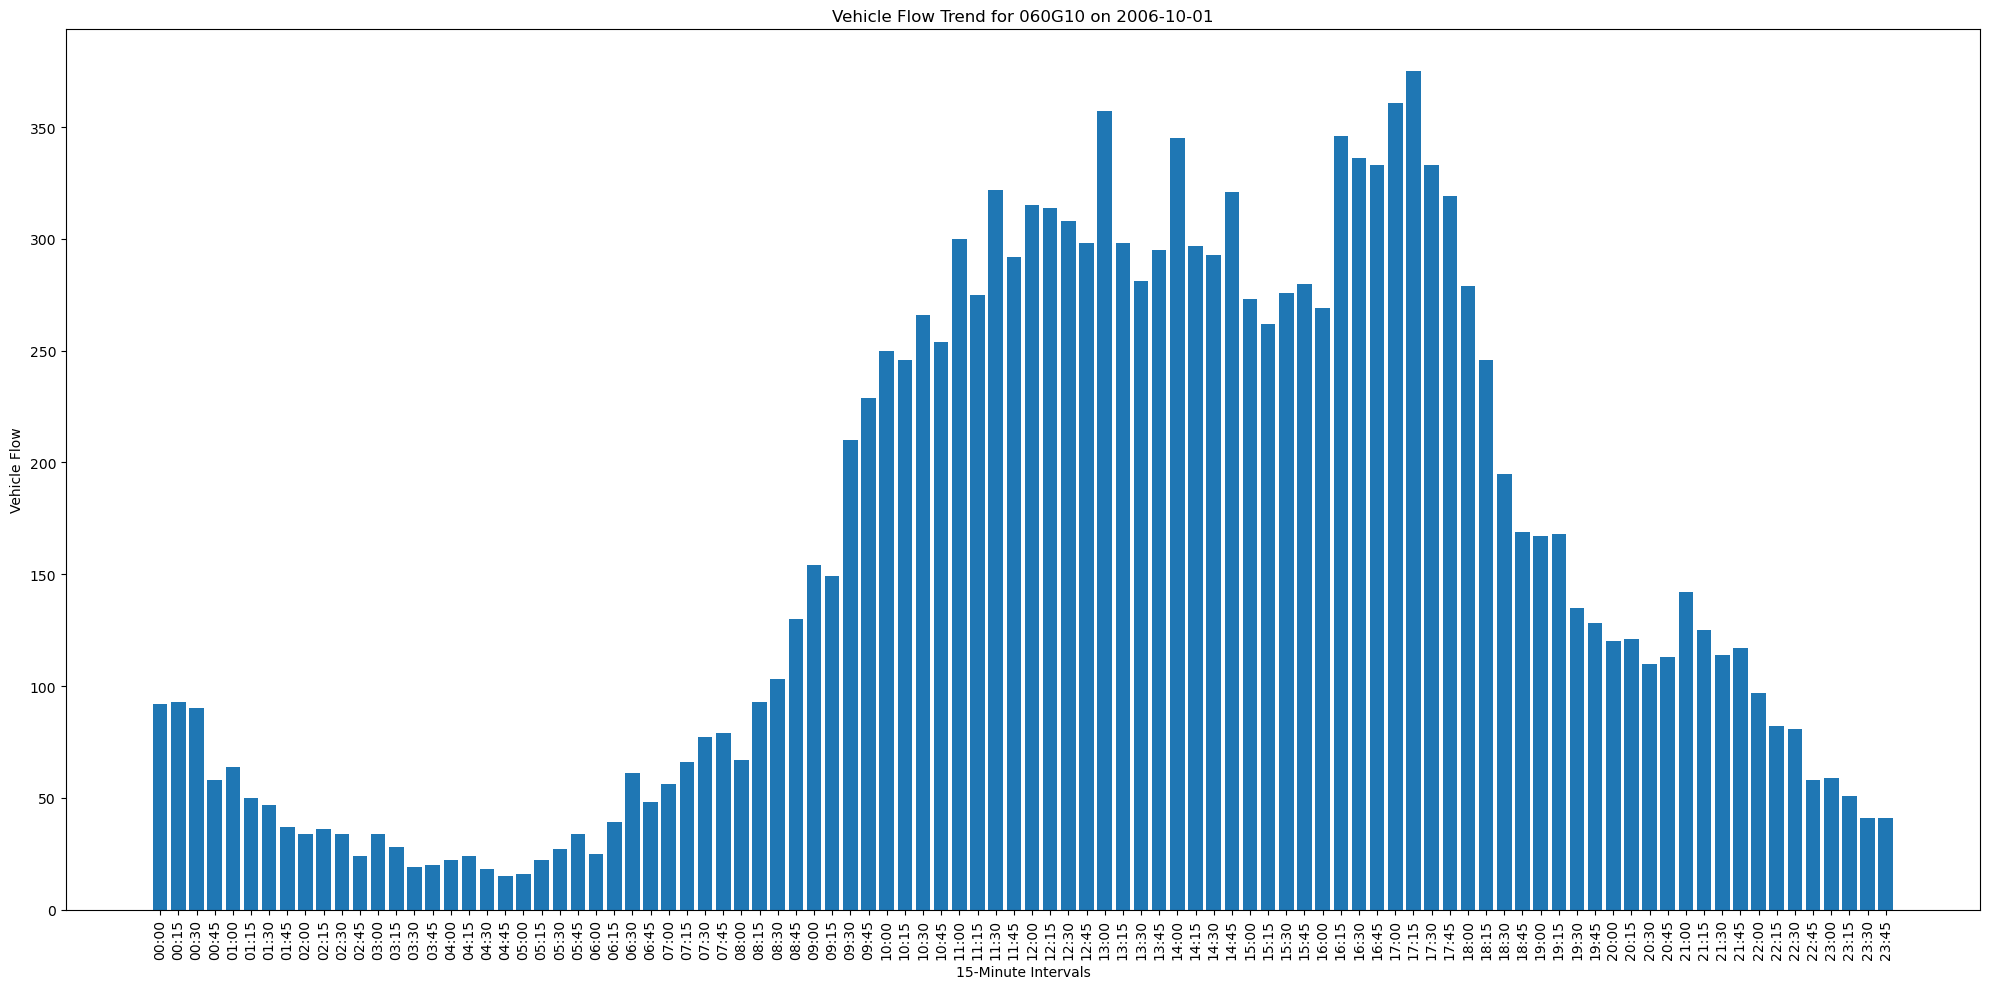

In [29]:
# It seems the previous session variables are not available, so let's reload the data and filtered dataframe

import pandas as pd
import matplotlib.pyplot as plt

# # Load the CSV file
# file_path = '/mnt/data/Out_9.csv'
# data = pd.read_csv(file_path)

# Convert 'Date' and 'Flow Vehicles' columns to appropriate data types
final_df_scats_october['Date'] = pd.to_datetime(final_df_scats_october['Date'], format='%d/%m/%y')
final_df_scats_october['Flow Vehicles'] = pd.to_numeric(final_df_scats_october['Flow Vehicles'], errors='coerce')

# Filtering criteria
selected_date = '2006-10-01'
selected_cd_melways = '060G10'

# Filter the data based on the selected date and CD_MELWAYS value
filtered_data = final_df_scats_october[(final_df_scats_october['Date'] == selected_date) & (final_df_scats_october['CD_MELWAYS'] == selected_cd_melways)]

# Re-plot the vehicle flow trend without point markers
# Re-plot the vehicle flow trend using a bar plot to avoid the straight line issue
plt.figure(figsize=(20, 10))
plt.bar(filtered_data['15_Minute_Intervals'], filtered_data['Flow Vehicles'])
plt.xlabel('15-Minute Intervals')
plt.ylabel('Vehicle Flow')
plt.title(f'Vehicle Flow Trend for {selected_cd_melways} on {selected_date}')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


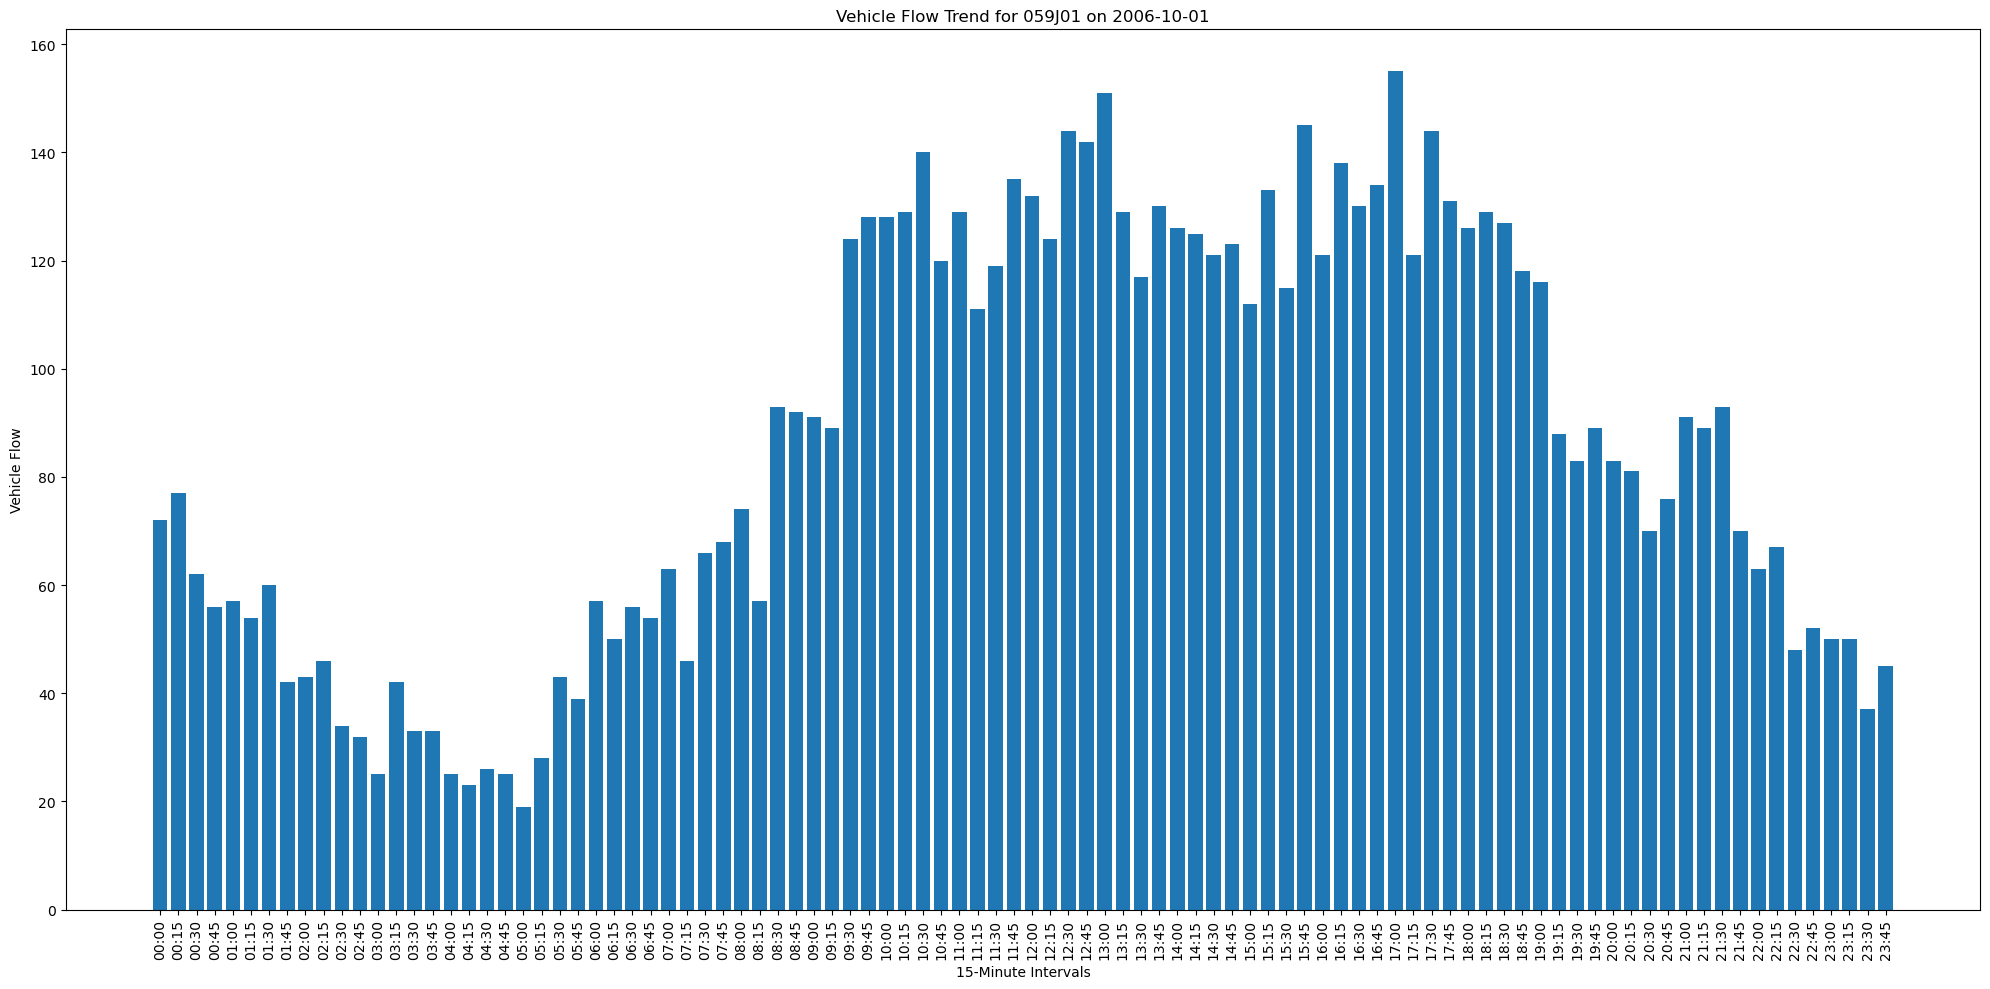

In [30]:
# Convert 'Date' and 'Flow Vehicles' columns to appropriate data types
final_df_scats_october['Date'] = pd.to_datetime(final_df_scats_october['Date'], format='%d/%m/%y')
final_df_scats_october['Flow Vehicles'] = pd.to_numeric(final_df_scats_october['Flow Vehicles'], errors='coerce')

# Filtering criteria
selected_date = '2006-10-01'
selected_cd_melways = '059J01'

# Filter the data based on the selected date and CD_MELWAYS value
filtered_data = final_df_scats_october[(final_df_scats_october['Date'] == selected_date) & (final_df_scats_october['CD_MELWAYS'] == selected_cd_melways)]

# Re-plot the vehicle flow trend without point markers
# Re-plot the vehicle flow trend using a bar plot to avoid the straight line issue
plt.figure(figsize=(20, 10))
plt.bar(filtered_data['15_Minute_Intervals'], filtered_data['Flow Vehicles'])
plt.xlabel('15-Minute Intervals')
plt.ylabel('Vehicle Flow')
plt.title(f'Vehicle Flow Trend for {selected_cd_melways} on {selected_date}')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
# plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show() 

In [31]:
df_scats_data_october

,SCATS Number,Location,CD_MELWAYS,NB_LATITUDE,NB_LONGITUDE,HF VicRoads Internal,VR Internal Stat,VR Internal Loc,NB_TYPE_SURVEY,Date,V00,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,Unnamed: 106,Unnamed: 107,Unnamed: 108
0,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,1/10/06,86,83,52,58,59,44,31,37,30,24,16,24,25,25,15,6,21,17,15,15,16,21,27,21,25,32,61,48,56,66,77,79,67,93,103,130,154,149,210,229,250,246,266,254,300,275,322,292,315,314,308,280,357,298,281,289,345,297,233,227,273,225,265,257,233,244,259,264,265,253,243,210,216,202,177,169,167,136,131,128,118,121,87,113,142,112,114,97,97,66,81,50,59,47,29,34,NaN,NaN,NaN
1,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,2/10/06,32,28,17,11,7,11,6,15,11,12,6,9,1,4,11,9,11,16,22,14,28,26,57,57,70,136,221,196,239,366,355,400,401,400,395,367,315,308,302,306,245,286,279,275,227,234,236,239,320,254,242,261,251,290,254,256,283,226,276,271,281,285,306,301,327,340,294,326,277,382,320,377,259,298,218,190,186,172,161,158,134,141,119,142,103,108,111,102,107,114,80,60,62,48,44,26,NaN,NaN,NaN
2,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,3/10/06,26,32,21,14,10,12,13,10,9,7,8,5,5,6,11,12,8,11,13,10,23,37,64,95,90,183,219,251,302,307,410,351,411,408,405,372,330,366,360,317,312,289,293,299,293,273,264,264,290,260,286,272,274,270,259,313,281,347,280,266,347,277,328,318,357,347,381,288,358,338,365,369,296,335,269,232,211,198,176,163,155,140,135,129,139,146,130,132,114,86,93,90,73,57,29,40,NaN,NaN,NaN
3,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,4/10/06,32,22,28,13,16,8,14,10,8,8,7,6,8,2,7,10,8,14,16,12,24,37,62,84,82,166,230,235,256,336,316,392,374,392,417,380,376,328,324,338,282,272,290,340,301,288,258,272,319,315,251,281,294,301,300,288,282,260,247,252,320,300,264,329,359,345,270,338,308,340,377,335,352,290,258,281,237,203,167,165,133,163,135,141,137,158,115,113,132,101,113,90,78,66,52,44,NaN,NaN,NaN
4,970,WARRIGAL_RD N of HIGH STREET_RD,060G10,-37.86703,145.09159,249,182,1,1,5/10/06,40,39,21,11,16,9,15,15,9,6,9,4,4,1,11,9,17,13,16,15,23,35,58,79,81,139,238,235,235,328,344,315,359,434,375,365,356,362,328,330,327,276,311,281,303,324,285,301,331,296,302,299,290,281,308,294,303,296,265,306,312,322,343,317,397,385,388,324,348,361,372,396,315,334,309,271,251,262,228,196,176,152,146,167,122,150,171,120,116,113,99,91,61,55,49,36,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,4821,VICTORIA_ST W OF BURNLEY_ST,002HF02,-37.81296,145.00830,6673,1513,7,1,27/10/06,51,56,43,29,35,19,24,21,15,20,19,14,16,15,13,14,11,15,14,21,17,22,34,51,36,66,109,103,113,136,138,141,218,174,167,168,166,146,163,142,170,158,173,147,194,173,186,151,206,199,218,197,201,197,232,206,205,212,194,215,224,229,253,223,240,261,305,268,303,270,333,264,341,255,214,229,224,204,150,189,164,167,115,133,127,122,122,121,127,103,122,124,117,99,108,88,NaN,NaN,NaN
4188,4821,VICTORIA_ST W OF BURNLEY_ST,002HF02,-37.81296,145.00830,6673,1513,7,1,28/10/06,91,87,89,72,64,81,58,47,52,43,33,47,36,37,27,24,23,35,26,15,16,25,27,24,29,30,38,55,57,50,80,96,79,74,105,110,129,140,154,184,176,163,196,188,193,191,219,224,200,240,223,236,225,200,226,222,216,223,227,219,221,211,236,218,235,242,220,177,201,185,175,154

### **Splitting the final dataset into smaller chunks for training (training is sorted by SCATS Number)**

In [33]:
final_df_scats_october

,Date,CD_MELWAYS,Scat_Number,15_Minute_Intervals,Flow Vehicles,DateTime
0,2006-10-01,060G10,970,00:00,86,NaT
1,2006-10-01,060G10,970,00:15,83,NaT
2,2006-10-01,060G10,970,00:30,52,NaT
3,2006-10-01,060G10,970,00:45,58,NaT
4,2006-10-01,060G10,970,01:00,59,NaT
...,...,...,...,...,...,...
393499,2006-10-31,002HF02,4821,22:45,87,NaT
393500,2006-10-31,002HF02,4821,23:00,75,NaT
393501,2006-10-31,002HF02,4821,23:15,63,NaT
393502,2006-10-31,002HF02,4821,23:30,51,NaT


In [34]:
#**reordering columns**

# Move 'DateTime' to the first column
new_column_order = ['DateTime'] + [col for col in final_df_scats_october.columns if col != 'DateTime']

# Reorder the DataFrame columns
final_df_scats_october = final_df_scats_october[new_column_order]

# Move 'SCATS_Number' to the last position
new_column_order = [col for col in final_df_scats_october.columns if col != 'Scat_Number'] + ['Scat_Number']

# Reorder the DataFrame
final_df_scats_october = final_df_scats_october[new_column_order]

# Insert a new column '# Lane Points' in the third position (index 2) and fill it with 1
final_df_scats_october.insert(2, '# Lane Points', 1)
final_df_scats_october.insert(3, '% Observed', 100)


In [35]:
#Dropping CD_MELWAYS column

final_df_scats_october.drop(columns=['CD_MELWAYS', 'Date', '15_Minute_Intervals'], inplace=True)

# Step 1: Remove the 'Flow_Vehicles' column and store its data
flow_vehicles_column = final_df_scats_october.pop('Flow Vehicles')

# Step 2: Reinsert 'Flow_Vehicles' at index 1 (second position)
final_df_scats_october.insert(1, 'Flow Vehicles', flow_vehicles_column)

In [36]:
final_df_scats_october.rename(columns={
    'DateTime': '5 Minutes',
    'Flow Vehicles': 'Lane 1 Flow (Veh/5 Minutes)',
    'Scat_Number': 'SCATS'
}, inplace=True)


In [37]:
final_df_scats_october

,5 Minutes,Lane 1 Flow (Veh/5 Minutes),# Lane Points,% Observed,SCATS
0,NaT,86,1,100,970
1,NaT,83,1,100,970
2,NaT,52,1,100,970
3,NaT,58,1,100,970
4,NaT,59,1,100,970
...,...,...,...,...,...
393499,NaT,87,1,100,4821
393500,NaT,75,1,100,4821
393501,NaT,63,1,100,4821
393502,NaT,51,1,100,4821


In [38]:
# # Split the DataFrame by 'SCATS_Number'
# scat_dfs = {scat: df_group for scat, df_group in final_df_scats_october.groupby('SCATS')}
# 
# # Save each SCATS_Number DataFrame to a separate CSV file
# for scat, group_df in scat_dfs.items():
#     group_df.to_csv(f'{scat}.csv', index=False)

